In [1]:
import os
os.chdir("..")  # 回到项目根目录

In [16]:
import geopandas as gpd
import pandas as pd

# 1. 读取主土地利用图斑数据
land = gpd.read_file("data/land.geojson").to_crs(epsg=4326)

# 2. 读取刚才转换过的五个组团区域 GeoJSON 文件
zones = gpd.read_file("data/xixian_zones_converted.geojson").to_crs(epsg=4326)

# 3. 中文组团名 → 英文名映射
name_map = {
    "空港新城": "Airport New City",
    "沣东新城": "Fengdong New City",
    "沣西新城": "Fengxi New City",
    "秦汉新城": "Qinhan New City",
    "泾河新城": "Jinghe New City"
}

zones["group"] = zones["name"].map(name_map)

# 4. 空间连接，划分每块土地所属组团
land_grouped = gpd.sjoin(land, zones[["geometry", "group"]], how='left', predicate='intersects')

# 5. 计算面积（km²）
land_grouped["area_km2"] = land_grouped.to_crs(epsg=3857).geometry.area / 1e6

# 6. 按组团与用地类型统计面积
area_summary = land_grouped.groupby(["group", "用地类型"])["area_km2"].sum().unstack(fill_value=0)

# 7. 导出为 Excel 文件
area_summary.to_excel("outputs/组团土地类型面积统计_统一英文名.xlsx", sheet_name="AreaStats")

# 8. 预览输出
area_summary.head()


用地类型,交通场站用地,住宅用地,体育用地,公共设施用地,公园绿地,公园设施用地,公用设施用地,共管区,农业用地,农林用地,...,商业用地,基础用地,基础绿地,工业用地,政府用地,教育用地,文化用地,水域,水域用地,社会福利用地
group,,,,,,,,,,,,,,,,,,,,,
Airport New City,16.611791,15.829263,0.000000,0.000000,0.676013,0.000000,1.977880,1.137945,195.778718,7.108142,...,8.736410,0.000000,0.484783,17.031108,0.011382,1.674212,0.131485,0.000000,0.000000,0.211624
Fengdong New City,4.507665,63.143900,0.826761,0.000000,9.487820,0.000000,1.004603,1.555422,89.146286,0.000000,...,23.767658,0.423915,6.685511,23.588782,0.127220,8.965160,2.101405,22.788742,0.080342,0.372231
Fengxi New City,21.163698,29.901431,0.000000,0.000000,6.733424,0.000000,1.522480,0.859753,98.811615,0.000000,...,10.012327,0.000000,1.505579,24.918293,0.246961,10.164720,0.592822,10.902513,0.000000,0.117542
Jinghe New City,52.594910,10.797821,0.000000,0.000000,1.296745,0.000000,0.504929,0.069642,62.540087,0.000000,...,6.800809,0.000000,0.032925,27.506473,0.000000,1.856985,0.614445,1.840546,0.000000,0.121055
Qinhan New City,203.673455,32.656790,0.000000,1.321051,2.296866,0.541215,0.000000,0.078330,288.959630,0.000000,...,16.068400,0.213254,1.934526,30.356391,0.104559,4.238426,0.687123,6.356501,0.000000,0.210009


In [17]:
# 1. 将 geometry 投影到米制坐标系（EPSG:3857）用于面积计算
zones_projected = zones.to_crs(epsg=3857)

# 2. 计算每个组团的总面积（单位：km²）
zones["total_area_km2"] = zones_projected.geometry.area / 1e6

# 3. 保存为 Excel 表格
zones[["group", "total_area_km2"]].to_excel("outputs/组团区域总面积统计.xlsx", index=False)

# 4. 显示预览
zones[["group", "total_area_km2"]]


,group,total_area_km2
0,NaN,1311.701814
1,Fengdong New City,258.749890
2,Fengxi New City,174.902460
3,Airport New City,231.584631
4,Jinghe New City,173.075181
5,Qinhan New City,462.079066


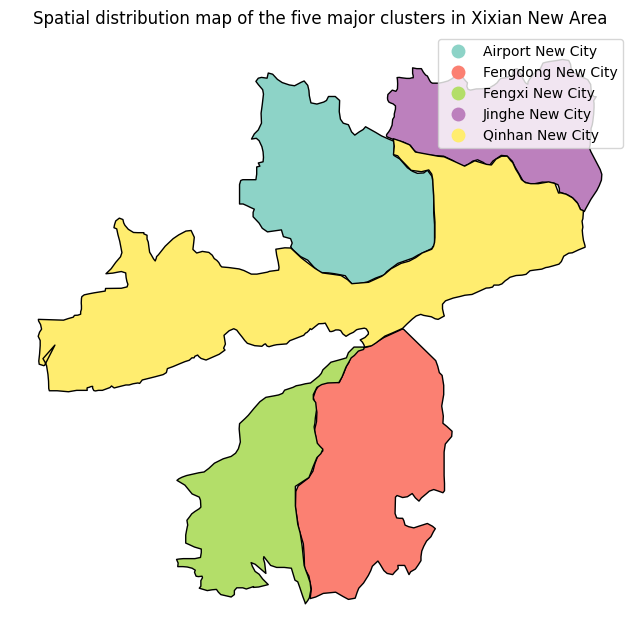

In [18]:
# 绘制五大组团区域地图（不加图例、标签，仅底图）
import matplotlib.pyplot as plt

# 重新绘制地图
fig, ax = plt.subplots(figsize=(8, 8))
zones.plot(ax=ax, column='group', cmap='Set3', legend=True, edgecolor='black')
ax.set_title("Spatial distribution map of the five major clusters in Xixian New Area", fontsize=12)
ax.axis('off')
plt.show()

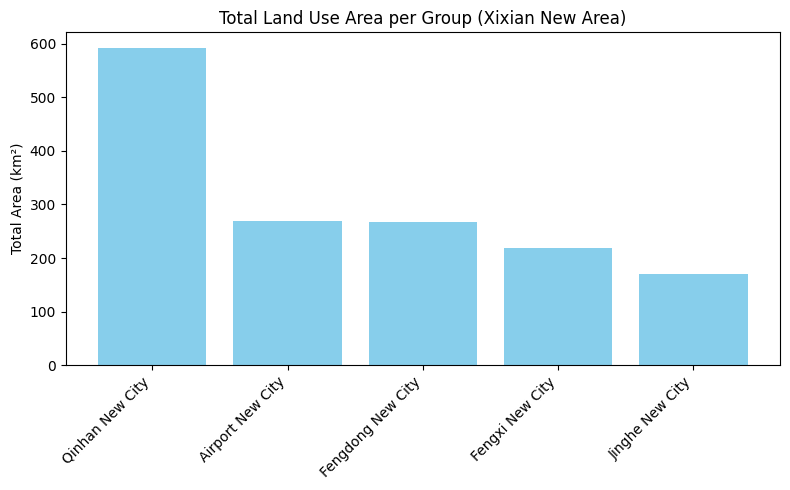

In [19]:
# 计算每个组团的总面积
area_total = land_grouped.groupby("group")["area_km2"].sum().sort_values(ascending=False).reset_index()

# 绘制柱状图
plt.figure(figsize=(8, 5))
plt.bar(area_total["group"], area_total["area_km2"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Area (km²)")
plt.title("Total Land Use Area per Group (Xixian New Area)")
plt.tight_layout()
plt.show()